# SpacePy Tutorial -- An introduction to using MMS MEC data files

- https://github.com/heliophysicsPy/summer-school-24/blob/main/spacepy-tutorial/SpacePy%20-%20MMS%20Ephemeris.md

NASA's Magnetospheric Multiscale (MMS) mission includes a slightly unusual instrument. MEC is the _Magnetic Ephemeris and Coordinates_ and while it's officially an instrument, it's actually a supporting team that provides data on the position and attitude of the spacecraft as well as some derived magnetic field-related quantities.

This tutorial introduces a few key tools and techniques in the SpacePy and scientific Python ecosystem through illustrative use on MMS data.

*We note that MEC files with a major version number of 1 (i.e. v1.x.x) give the quaternions to rotate the frame.
MEC files with a major version number of >=2 (i.e. 2.x.x) give the quaternion to rotate the vector.*

*If using the version 1.x.x files the expected vector rotation can be found by taking the conjugates of each quaternion.*

### Setup
This tutorial uses geomagnetic index and leapsecond data that SpacePy normally maintains on a per-user basis. (To download this data on your own installation of SpacePy, use [spacepy.toolbox.update()](https://spacepy.github.io/autosummary/spacepy.toolbox.html#spacepy.toolbox.update).

In [ ]:
# Update geomagnetic index and leapsecond data
import spacepy.toolbox
# spacepy.toolbox.update(all=True)

spacepy.toolbox.update(omni2=True)
spacepy.toolbox.update(leapsecs=True)

Finding OMNI2 files to download ...
Listing files ...100%
Retrieving OMNI2 files ...
Download Progress ...100%
Retrieving leapseconds file ... 


'C:\\Users\\usr\\.spacepy\\data'

> In the meantime, Steve generated up-to-date files and I've processed them into the final parsed SpacePy database. That can be downloaded [here](https://spp-isois.sr.unh.edu/data_public/omni/omnidata.h5). Place that .h5 file in the data directory inside the [Spacepy DOT_FLN directory](https://spacepy.github.io/configuration.html).

- https://github.com/spacepy/spacepy/issues/731

In [ ]:
import os 

#start with some necessary module imports
import urllib.request
import numpy as np
import spacepy.coordinates as spc
import spacepy.datamodel as dm
import spacepy.toolbox as tb
import matplotlib.dates as mpd

#now some plotting setup
import matplotlib.pyplot as plt  # imports plot library
import spacepy.plot as splot  # gets spacepy plot tools and style sheets

splot.style('default')

In [ ]:
tutorial_data = os.path.expanduser('./spacepy_tutorial')  # Point this to wherever you want data to go.

First let's check whether we have the data file to work on...
If the named file isn't in this directory then we'll attempt to download it from the MMS SDC

In [ ]:
dname = 'mms1_mec_srvy_l2_ephts04d_20201011_v2.2.1.cdf'
data_dir = os.path.join(tutorial_data, 'mms')
fname = os.path.join(data_dir, dname)
# make sure the output directory exists first
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
# and then if the files aren't present, download them
if not os.path.isfile(fname):
    siteurl = 'https://lasp.colorado.edu/mms/sdc/public/files/api/v1/download/science?file='
    dataurl = ''.join([siteurl, dname])
    urllib.request.urlretrieve(dataurl, filename=fname)

In [ ]:
mmsdata = dm.fromCDF(fname)

### Browse the data
To look at all the variables in a CDF loaded using SpacePy's datamodel we can just call the *tree* method. By setting the *verbose* keyword to **True** we can see the dimensions of each variable, and by setting the *attrs* keyword to **True** we'd be able to display the metadata associated with each variable.

Each file has a lot of variables, each with a lot of metadata, so to avoid filling the screen here we won't show the attributes.

In [ ]:
mmsdata.tree(verbose=True)

+
|____3vec_representation (spacepy.pycdf.VarCopy (3,))
|____Epoch (spacepy.pycdf.VarCopy (2880,))
|____mms1_mec_L_phase (spacepy.pycdf.VarCopy (2880, 1))
|____mms1_mec_L_vec (spacepy.pycdf.VarCopy (2880, 2))
|____mms1_mec_L_vec_label (spacepy.pycdf.VarCopy (2,))
|____mms1_mec_P_phase (spacepy.pycdf.VarCopy (2880, 1))
|____mms1_mec_P_vec (spacepy.pycdf.VarCopy (2880, 2))
|____mms1_mec_P_vec_label (spacepy.pycdf.VarCopy (2,))
|____mms1_mec_Z_phase (spacepy.pycdf.VarCopy (2880, 1))
|____mms1_mec_Z_vec (spacepy.pycdf.VarCopy (2880, 2))
|____mms1_mec_Z_vec_label (spacepy.pycdf.VarCopy (2,))
|____mms1_mec_bfn_gsm (spacepy.pycdf.VarCopy (2880, 4))
|____mms1_mec_bfn_gsm_label (spacepy.pycdf.VarCopy (4,))
|____mms1_mec_bfs_gsm (spacepy.pycdf.VarCopy (2880, 4))
|____mms1_mec_bfs_gsm_label (spacepy.pycdf.VarCopy (4,))
|____mms1_mec_bmin_gsm (spacepy.pycdf.VarCopy (2880, 4))
|____mms1_mec_bmin_gsm_label (spacepy.pycdf.VarCopy (4,))
|____mms1_mec_bsc_gsm (spacepy.pycdf.VarCopy (2880, 4))
|____mms1

### To view metadata we just ask for the "attrs" of the variable
As noted above, the names of variable attributes can be visualized by *tree* when we add the *attrs* keyword.

In [ ]:
print(mmsdata['mms1_mec_quat_eci_to_gse'].attrs)

{'CATDESC': 'Quaternion rotation from GEI/J2000 to GSE (ECI to GSE). ((qx,qy,qz), qw)', 'FIELDNAM': 'mms1_mec_quat_eci_to_gse', 'SCALETYP': 'linear', 'VALIDMIN': -100000.0, 'VALIDMAX': 100000.0, 'FILLVAL': -1e+31, 'VAR_TYPE': 'data', 'FORMAT': 'F18.6', 'UNITS': ' ', 'SI_CONVERSION': ' > ', 'DEPEND_0': 'Epoch', 'COORDINATE_SYSTEM': 'GEI', 'DISPLAY_TYPE': 'time_series', 'TO_COORDINATE_SYSTEM': 'GSE', 'LABL_PTR_1': 'mms1_mec_quat_eci_to_gse_label', 'REPRESENTATION_1': 'quaternion_representation', 'TENSOR_ORDER': 1}


To get a "prettier" display of the attributes, we can iterate over the members and print the attribute name and contents.

In [ ]:
for key, value in mmsdata['mms1_mec_quat_eci_to_gse'].attrs.items():
    print('{0}: {1}'.format(key, value))

CATDESC: Quaternion rotation from GEI/J2000 to GSE (ECI to GSE). ((qx,qy,qz), qw)
FIELDNAM: mms1_mec_quat_eci_to_gse
SCALETYP: linear
VALIDMIN: -100000.0
VALIDMAX: 100000.0
FILLVAL: -1e+31
VAR_TYPE: data
FORMAT: F18.6
UNITS:  
SI_CONVERSION:  > 
DEPEND_0: Epoch
COORDINATE_SYSTEM: GEI
DISPLAY_TYPE: time_series
TO_COORDINATE_SYSTEM: GSE
LABL_PTR_1: mms1_mec_quat_eci_to_gse_label
REPRESENTATION_1: quaternion_representation
TENSOR_ORDER: 1


The [plot](https://spacepy.github.io/autosummary/spacepy.datamodel.ISTPContainer.html#spacepy.datamodel.ISTPContainer.plot) method of SpaceData allows for some quick and easy plots of the variables:

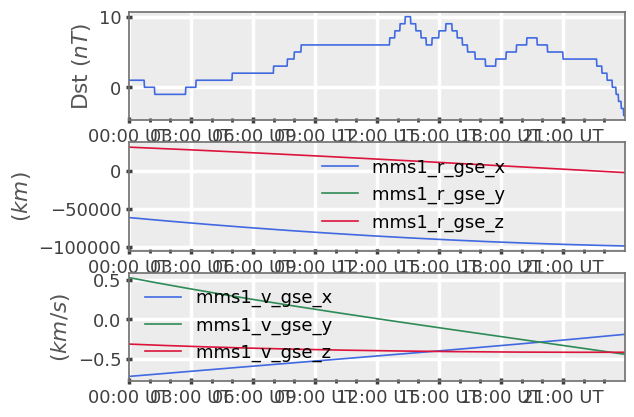

In [ ]:
fig = mmsdata.plot(["mms1_mec_dst", "mms1_mec_r_gse", "mms1_mec_v_gse"])

### So how do we use these quaternions?
The first test is to transform a set of known positions from one coordinate system to another. Here we'll go from GSE to GSM. We note that these values are not calculated with quaternions, but with rotation matrices in LANLGeoMag's CTrans routines. LANLGeoMag is available on github at: https://github.com/drsteve/LANLGeoMag. However, the SpacePy backend for coordinate transformation implements the same approach and calculates the results to the same accuracy with one major caveat: the MMS mission adopted the JPL DE421 model to specify the relative positions of all the bodies in the solar system, and this is how the Earth-Sun vector is derived. In SpacePy, there's currently only one method for calculating the Earth-Sun vector and it's a functional form rather than a fit to data (like the JPL DE models). However, in most cases the differences will be small.

So let's take the mms1_mec_r_gse position vectors and use the quaternions to rotate from GSE to GSM. Then we'll compare to the GSM values in the files to ensure we've done this correctly.

All the quaternions are given as eci_to*_targetsystem* . So to get from GSE to GSM, we need to take the following steps:
 - Take the conjugate of the ECI->GSE quaternion, giving a GSE->ECI quaternion.
 - Multiply the ECI->GSM quaternion by the GSE->ECI quaternion (Note the order is mult(rot2, rot1), where rot1 is the first transformation you want to make).
 - Use the resultant quaternion to rotate the vectors into the target system.

In [ ]:
quat_gse_to_eci = spc.quaternionConjugate(mmsdata['mms1_mec_quat_eci_to_gse'])
quat_gse_to_gsm = spc.quaternionMultiply(mmsdata['mms1_mec_quat_eci_to_gsm'], quat_gse_to_eci)

We know that GSE and GSM share the X-axis, so let's verify that the X axis is the same. We'll also look at the Z-axis, which should be different, though not radically so.

In [ ]:
# let's set numpy's print precision for tidiness
np.set_printoptions(precision=3)

print('X = {}'.format(spc.quaternionRotateVector(quat_gse_to_gsm[0], [1,0,0])))
print('Z = {}'.format(spc.quaternionRotateVector(quat_gse_to_gsm[0], [0,0,1])))
print('and the quaternion we used for this is\n({0})'.format(quat_gse_to_gsm[0]))

X = [1.000e+00 3.495e-16 1.194e-16]
Z = [-1.976e-16  2.331e-01  9.725e-01]
and the quaternion we used for this is
([-1.174e-01 -7.980e-17  1.665e-16  9.931e-01])


It's important to note here that there are two conventions for the representation of quaternions. Quaternions have three vector parts *(i,j,k)* and a scalar part *(w)*, thus the scalar part can be the first, or last, element.

We store the scalar part in the final element of a 1x4 array.

We can see that our unit vector along _X_ is basically [1, 0, 0] as 1e-17 is smaller than the floating point precision...
Similarly, our _Z_ unit vector has now been rotated so it has non-zero _Y_ and _Z_ components in GSM.

In [ ]:
print('{}'.format(np.finfo(float)))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
smallest_normal = 2.2250738585072014e-308   smallest_subnormal = 4.9406564584124654e-324
---------------------------------------------------------------



### Comparing the computed positions
Since that all looks about right, let's rotate the first three elements of mms1_mec_r_gse into GSM and compare to mms1_mec_r_gsm

In [ ]:
print('The first three GSE position vectors [km] are\n{}\n'.format(mmsdata['mms1_mec_r_gse'][:3]))
print('The first three GSM position vectors [km] are\n{}\n'.format(mmsdata['mms1_mec_r_gsm'][:3]))
myRgsm = spc.quaternionRotateVector(quat_gse_to_gsm[:3], mmsdata['mms1_mec_r_gse'][:3])
print('The first three (my) GSM position vectors [km] are\n{}\n'.format(myRgsm))
print('The conversion error [km] is\n{}'.format(myRgsm - mmsdata['mms1_mec_r_gsm'][:3])) #should all be approx. zero

The first three GSE position vectors [km] are
[[-61440.415 144051.508  31199.279]
 [-61461.273 144067.709  31189.849]
 [-61482.125 144083.898  31180.417]]

The first three GSM position vectors [km] are
[[-61440.415 147355.908  -3235.507]
 [-61461.273 147369.087  -3265.52 ]
 [-61482.125 147382.247  -3295.647]]

The first three (my) GSM position vectors [km] are
[[-61440.415 147355.908  -3235.507]
 [-61461.273 147369.087  -3265.52 ]
 [-61482.125 147382.247  -3295.647]]

The conversion error [km] is
[[-5.821e-11 -8.731e-11 -1.637e-11]
 [-1.965e-10 -5.821e-11  3.183e-12]
 [-3.638e-11  0.000e+00  2.228e-11]]


The differences are all extremely small. 1x10<sup>-11</sup> kilometers is 1 nanometer!

Let's try a different conversion, but using SpacePy's `coordinates`.

In [ ]:
import spacepy.time as spt
spc.DEFAULTS.set_values(use_irbem=False, itol=0)
tts = spt.Ticktock(mmsdata['Epoch'][-3:])
cc_ECI = spc.Coords(mmsdata['mms1_mec_r_eci'][-3:], 'ECI2000', 'car', ticks=tts)
cc_GEO = cc_ECI.convert('GEO', 'car')
print('The first three GEO position vectors [km] are\n{}\n'.format(mmsdata['mms1_mec_r_geo'][-3:]))
print('Using SpacePy instead of the supplied quaternions we get\n{}\n'.format(cc_GEO.data))
print('The conversion error [km] is\n{}'.format(cc_GEO.data - mmsdata['mms1_mec_r_geo'][-3:])) #should all be approx. zero

The first three GEO position vectors [km] are
[[  98274.759 -140655.352  -44501.497]
 [  97974.278 -140853.318  -44507.253]
 [  97673.396 -141050.634  -44513.005]]

Using SpacePy instead of the supplied quaternions we get
[[  98274.759 -140655.352  -44501.497]
 [  97974.278 -140853.318  -44507.253]
 [  97673.396 -141050.634  -44513.005]]

The conversion error [km] is
[[ 2.609e-06  2.191e-06 -1.162e-06]
 [ 1.863e-06  1.663e-06 -1.161e-06]
 [ 2.193e-06  1.885e-06 -1.160e-06]]


Again, there's a difference here... 1x10<sup>-6</sup>km is 100 millimeters, which is probably due to differencing roundoff errors between the two calculations.

What if we start with the GSE position and convert to ECI(J2000) using both?

In [ ]:
tts = spt.Ticktock(mmsdata['Epoch'][-3:])
cc_GSE = spc.Coords(mmsdata['mms1_mec_r_gse'][-3:], 'GSE', 'car', ticks=tts)
cc_ECI = cc_GSE.convert('ECI2000', 'car')
print('The first three ECI() position vectors [km] are\n{}\n'.format(mmsdata['mms1_mec_r_eci'][-3:]))
print('Using SpacePy instead of the supplied quaternions we get\n{}\n'.format(cc_ECI.data))
print('The conversion error [km] is\n{}'.format(cc_ECI.data - mmsdata['mms1_mec_r_eci'][-3:]))

The first three ECI() position vectors [km] are
[[141032.443 -97605.002 -44781.169]
 [141033.568 -97586.761 -44786.927]
 [141034.685 -97568.513 -44792.681]]

Using SpacePy instead of the supplied quaternions we get
[[141044.614 -97590.36  -44774.748]
 [141045.738 -97572.119 -44780.505]
 [141046.852 -97553.871 -44786.26 ]]

The conversion error [km] is
[[12.171 14.642  6.421]
 [12.169 14.642  6.422]
 [12.168 14.642  6.422]]


The magnitude of error here is about 13km in the X position, and that conversion error doesn't change much with time. This is primarily due to the specific Earth-Sun position vector used in the MMS ephemeris calculation, which is different to that used by SpacePy. Of course, the relative differences between locations will be the same regardless of which transformation we use.

To see the difference made by using a lower accuracy transformation, change the backend to use the IRBEM library. You can do this either with a keyword argument when setting up your `Coords`, or by updating your deafult settings for `spacepy.coordinates`.

So, now that we've demonstrated how to use the quaternions to get from one system to another, let's get some actual data and transform it from satellite coordinates into a geophysical system.

Again, we'll need to grab a data file. For this example we'll use "FGM" magnetometer data.

In [ ]:
dname = 'mms1_fgm_srvy_l2_20201011_v5.263.0.cdf'
fname = os.path.join(tutorial_data, 'mms', dname)
if not os.path.isfile(fname):
    siteurl = 'https://lasp.colorado.edu/mms/sdc/public/files/api/v1/download/science?file='
    dataurl = ''.join([siteurl, dname])
    urllib.request.urlretrieve(dataurl, filename=fname)

In [ ]:
#use SpacePy's datamodel for a convenient read -- a more direct interface to the CDF library is in spacepy.pycdf
# This is a big file, so let's use directly do just access what we want!
from spacepy import pycdf
fields = pycdf.CDF(fname)  # opens file, but doesn't read anything yet
# We should close this later, or open it using a context manager
# and just load what we need up front.

In [ ]:
#extract the indices in the FIELDS file that are in the time-range given by the MEC file
inds = tb.tOverlapHalf(mmsdata['Epoch'], fields['Epoch'][...])

### Explore the data file, then visualize the B-field

In [ ]:
tb.dictree(fields)

+
|____Epoch
|____Epoch_state
|____label_b_bcs
|____label_b_dmpa
|____label_b_gse
|____label_b_gsm
|____label_r_gse
|____label_r_gsm
|____mms1_fgm_b_bcs_srvy_l2
|____mms1_fgm_b_dmpa_srvy_l2
|____mms1_fgm_b_gse_srvy_l2
|____mms1_fgm_b_gsm_srvy_l2
|____mms1_fgm_bdeltahalf_srvy_l2
|____mms1_fgm_etemp_srvy_l2
|____mms1_fgm_flag_srvy_l2
|____mms1_fgm_hirange_srvy_l2
|____mms1_fgm_mode_srvy_l2
|____mms1_fgm_r_gse_srvy_l2
|____mms1_fgm_r_gsm_srvy_l2
|____mms1_fgm_rdeltahalf_srvy_l2
|____mms1_fgm_stemp_srvy_l2
|____represent_vec_tot


Note that data is provided here in four coordinate systems:
- BCS: Body Centered System
- DMPA: Despun Major Principal Axis
- GSE: Geocentric Solar Ecliptic
- GSM: Geocentric Solar Magnetospheric

For information about GSE and GSM, and other geophysical systems, see the [spacepy.coords](https://spacepy.github.io/coordinates.html) and [spacepy.ctrans](https://spacepy.github.io/ctrans.html) docs. The other two systems are MMS specific. BCS rotates with the spacecraft around the instantaneous spin axis (Z-axis). MPA - not used here - is similat to BCS, but the Z-axis is effectively the mean spin axis over a period of spin axis nutation. If there's no nutation, MPA and BCS should be the same. DMPA is _despun_ meaning that the X axis lies in the Sun-Earth plane.

Note that the Z-axis for BCS/MPA/DMPA is close to Earth's spin axis, so DMPA ends up being relatively close to GSE. Not close enough for many detailed analyses, but close enough that you can use it as a sanity check.

In [ ]:
bvar = 'mms1_fgm_b_dmpa_srvy_l2'
for key, value in fields[bvar].attrs.items():
    print('{0}: {1}'.format(key, value))

CATDESC: Magnetic field vector in Despun MPA-aligned cartesian coordinates plus Btotal (8 or 16 S/s)
DEPEND_0: Epoch
DISPLAY_TYPE: time_series
FIELDNAM: Magnetic field vector in DMPA plus Btotal (8 or 16 S/s)
FILLVAL: -9.999999848243207e+30
FORMAT: E13.5
LABL_PTR_1: label_b_dmpa
UNITS: nT
VALIDMIN: [-17000. -17000. -17000.      0.]
VALIDMAX: [17000. 17000. 17000. 17000.]
VAR_TYPE: data
SCALETYP: linear
VAR_NOTES: During nominal operatins in the region of interest, DMPA is within 3 degrees of GSE.  
COORDINATE_SYSTEM: DMPA>Despun Major Principal Axis
SI_CONVERSION: 1.0e-9>T
TENSOR_ORDER: 1
REPRESENTATION_1: represent_vec_tot


In [ ]:
mec_ticks = spt.Ticktock(mmsdata['Epoch'])
tt = mec_ticks.TAI
fieldstt = spt.Ticktock(fields['Epoch'][...]).TAI

We're looking at a day of survey mode B-field data, so let's assume it's fine to just do a linear interpolation on the samples to get the data at the sample times in the MEC file. The MEC survey files have 30 second cadence; MEC burst mode files have 30 millisecond cadence.

In [ ]:
fieldsDMPA = np.empty([len(mmsdata['Epoch']), 3])
fieldsDMPA[:,0] = np.interp(tt, fieldstt, fields[bvar][:,0], left=np.nan, right=np.nan)
fieldsDMPA[:,1] = np.interp(tt, fieldstt, fields[bvar][:,1], left=np.nan, right=np.nan)
fieldsDMPA[:,2] = np.interp(tt, fieldstt, fields[bvar][:,2], left=np.nan, right=np.nan)
mag = tb.interpol(tt, fieldstt, fields[bvar][:,3])

### So new let's display the FGM data, in DMPA coordinates, interpolated to the MEC timestamps

But first, before we forget, let's close the CDF file...

<matplotlib.legend.Legend>

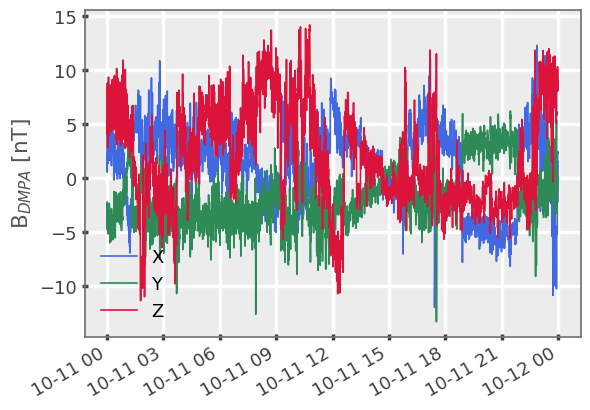

In [ ]:
fields.close()
# And back to the plotting
fig = plt.figure()
ax = fig.add_subplot(111)
lObj = ax.plot(mmsdata['Epoch'], fieldsDMPA)
ax.set_ylabel('B$_{DMPA}$ [nT]')
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z', 'Tot'])

### And now we need to do the conversion of the field vector from DMPA to GSM

Again we apply quaternion math, first making a quaternion to go from DMPA to ECI(J2000), then multiply that to get a quaternion that rotates our vector from DMPA to GSM.

In [ ]:
quat_dmpa_to_eci = spc.quaternionConjugate(mmsdata['mms1_mec_quat_eci_to_dmpa'])
quat_dmpa_to_gsm = spc.quaternionMultiply(mmsdata['mms1_mec_quat_eci_to_gsm'], quat_dmpa_to_eci)

field_gsm = spc.quaternionRotateVector(quat_dmpa_to_gsm, fieldsDMPA)

### Let's plot the DMPA and the GSM side by side

<matplotlib.legend.Legend>

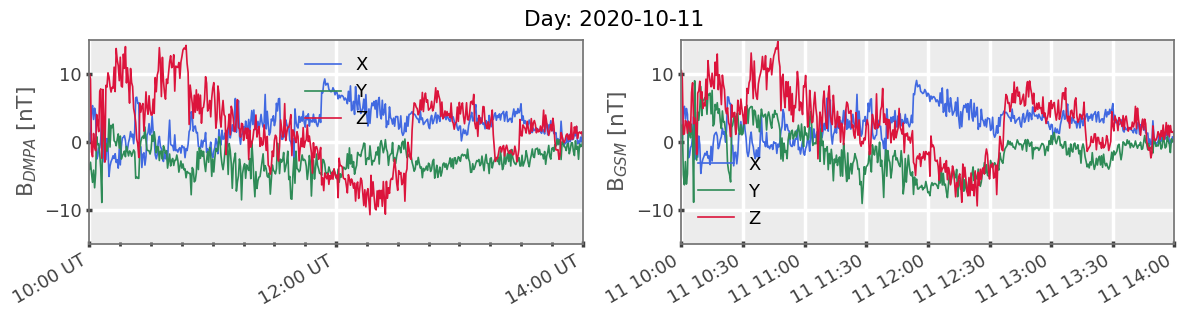

In [ ]:
timelims = spt.Ticktock(['2020-10-11T10:00:00', '2020-10-11T14:00:00']).UTC
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(121)
lObj = ax.plot(mmsdata['Epoch'], fieldsDMPA)
ax.set_ylabel('B$_{DMPA}$ [nT]')
ax.set_xlim(timelims)
splot.applySmartTimeTicks(ax, timelims)
plt.legend(lObj, ['X','Y','Z'])
plt.subplots_adjust()
fig.suptitle('Day: {0}'.format(mmsdata['Epoch'][0].date().isoformat()))
ax.set_ylim([-15, 15])

ax = fig.add_subplot(122)
lObj = ax.plot(mmsdata['Epoch'], field_gsm)
ax.set_ylabel('B$_{GSM}$ [nT]')
ax.set_xlim(timelims)
ax.set_ylim([-15, 15])
fig.autofmt_xdate()
plt.legend(lObj, ['X','Y','Z'])

### Can we do _this_ transformation using SpacePy's Coords?

So far we've only transformed positions with `spacepy.coordinates.Coords`. So can we use `Coords` to transform arbitrary vectors between coordinate systems?

We'll test this by using the quaternions to get from DMPA to ECI(J2000), as the former is satellite-specific. Then we'll use `spacepy.coordinates.Coords` to rotate our magnetic field from ECI(J2000) to GSM.

<matplotlib.legend.Legend>

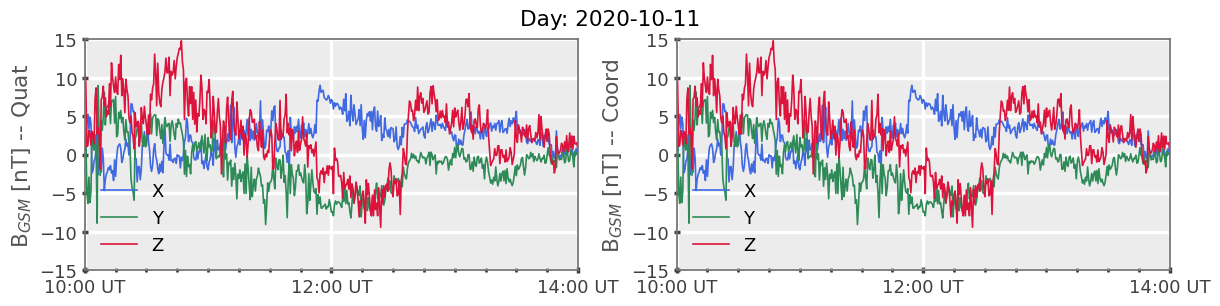

In [ ]:
# For speed, let's set our "cache" to 5 minutes (300s) ...
# The accuracy required will depend on your application,
# and whether you are transforming to GEO!
spc.DEFAULTS.set_values(use_irbem=False, itol=300)

# Now rotate to ECI, make a Coords, then transform to GSM using that.
field_eci = spc.quaternionRotateVector(quat_dmpa_to_eci, fieldsDMPA)
field_ecispc = spc.Coords(field_eci, 'ECI2000', 'car', ticks=mec_ticks)
field_gsmspc = field_ecispc.convert('GSM', 'car')

# And plot as before
timelims = spt.Ticktock(['2020-10-11T10:00:00', '2020-10-11T14:00:00']).UTC
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(121)
lObj = ax.plot(mmsdata['Epoch'], field_gsm)
ax.set_ylabel('B$_{GSM}$ [nT] -- Quat')
ax.set_xlim(timelims)
splot.applySmartTimeTicks(ax, timelims)
plt.legend(lObj, ['X','Y','Z'])
plt.subplots_adjust()
fig.suptitle('Day: {0}'.format(mmsdata['Epoch'][0].date().isoformat()))
ax.set_ylim([-15, 15])

ax = fig.add_subplot(122)
lObj = ax.plot(mmsdata['Epoch'], field_gsmspc.data)
ax.set_ylabel('B$_{GSM}$ [nT] -- Coord')
ax.set_xlim(timelims)
ax.set_ylim([-15, 15])
splot.applySmartTimeTicks(ax, timelims)
plt.legend(lObj, ['X','Y','Z'])

**Isn't _that_ reassuring!**

While we mostly use position vectors in examples for `Coords`, there's no reason (most of the time) that you can't use `Coords` to represent and transform arbitrary vectors between coordinate systems.

This won't work for coordinate systems like ENU (or the ground-based magnetometer favorite, NED) as they are _position-dependent_ transforms. There's [a discussion on out github](https://github.com/spacepy/spacepy/discussions/563) about this. Geodetic coordinates are another exception, as the use of an ellipsoid Earth means that a Cartesian representation makes no sense and the "local vertical" is not radially-outward. So again this is position dependent. Some common use cases may be supported in a future version of SpacePy, so watch this space.

### Interoperability with AstroPy coordinates

One last fun (?) task to show more package interoperability...
Imagine you have a special satellite-tracking telescope on the roof of your cabin at _Bear Mountain_. It's got the latest Alt-Az mount and will slew to whatever [Alt-Az coordinates](https://docs.astropy.org/en/stable/api/astropy.coordinates.AltAz.html) you punch in.
- Alt-Az stands for Altitude-Azimuth where _azimuth_ is an angle positive Eastward of North and _altitude_ is the elevation angle

In [ ]:
# This example is shamelessly modified from https://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html
import astropy.units as apu
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
mms_spc = spc.Coords(mmsdata['mms1_mec_r_eci'][0], 'ECI2000', 'car', ticks=mec_ticks[0])
mms_ap = mms_spc.to_skycoord()
bear_mountain = EarthLocation(lat=41.3*apu.deg, lon=-74*apu.deg, height=390*apu.m)
utcoffset = -4*apu.hour  # Eastern Daylight Time
time = mec_ticks.APT[0] - utcoffset
mmsaltaz = mms_ap.transform_to(AltAz(obstime=time, location=bear_mountain))
print("MMS's Altitude (angle), Azimuth = {:g}, {:g}".format(mmsaltaz.alt[0], mmsaltaz.az[0]))

MMS's Altitude (angle), Azimuth = 20.2492 deg, 240.915 deg


So MMS should be viewable from our stated location at Bear Mountain, at the start of the day we were looking at.

Finally, there's nothing in this notebook (except the data) that's MMS-specific. Do you have vector-rotating quaternions? Do you have vectors you need to rotate between standard geophysical systems? No mission-specific support is required. We target _generic_ tools. And as interoperability between Python packages in the Heliophysics arena continues to increase, you can use the best tool for each particular job, flexibly. Building on top of the ecosystem saves time and effort, while reaping the benefits of well-tested code.
